## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

In [2]:
# specify if you want to add high-resolution P1D (only working for Pedersen23 emulator)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=4

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
#emulator=nn_emulator.NNEmulator(training_set='Nyx23',emulator_label='Cabayol23_Nyx')
emulator=nn_emulator.NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23')
#emulator=gp_emulator.GPEmulator(training_set='Pedersen21',kmax_Mpc=kmax_Mpc)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
#data=mock_data.Mock_P1D(emulator=emulator,data_label="QMLE_Ohio")
data=mock_data.Mock_P1D(emulator=emulator,data_label="Chabanier2019")

In [5]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data=mock_data.Mock_P1D(emulator=emulator,data_label="Karacayli2022")
else:
    extra_data=None

### Set free parameters and theory

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

In [8]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


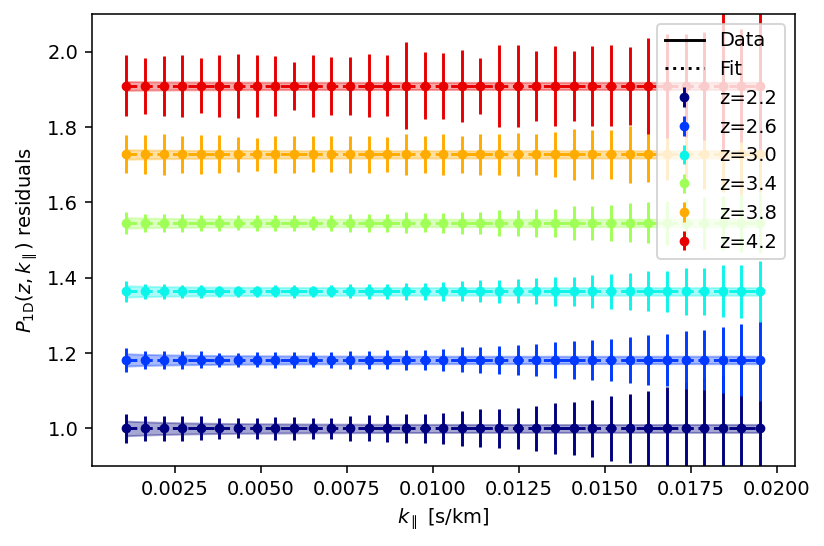

In [10]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=2)

In [11]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

### Run iminuit minimizer

In [12]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.00002
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.50001354 0.49998356 0.50000246 0.50001925 0.49999177 0.5000132
 0.50000219 0.50001891 0.50000091 0.49999914]
As = 2.100029785263191e-09 , 1e-09 , 3.2e-09
ns = 0.9649972044907257 , 0.88 , 1.05
ln_tau_0 = 4.925466671884537e-07 , -0.1 , 0.1
ln_sigT_kms_0 = 1.5400495600004227e-05 , -0.4 , 0.4
ln_gamma_0 = -3.2934607202828037e-06 , -0.2 , 0.2
ln_kF_0 = 5.2804921822358075e-06 , -0.2 , 0.2
ln_tau_1 = 8.741250902555286e-07 , -0.2 , 0.2
ln_sigT_kms_1 = 1.5124300596525142e-05 , -0.4 , 0.4
ln_gamma_1 = 7.277760355473006e-07 , -0.4 , 0.4
ln_kF_1 = -6.886353260959766e-07 , -0.4 , 0.4


In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [14]:
minimizer.minimize(compute_hesse=True)

In [15]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

1.032213702291323e-06

In [16]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

9.97371906488052e-06

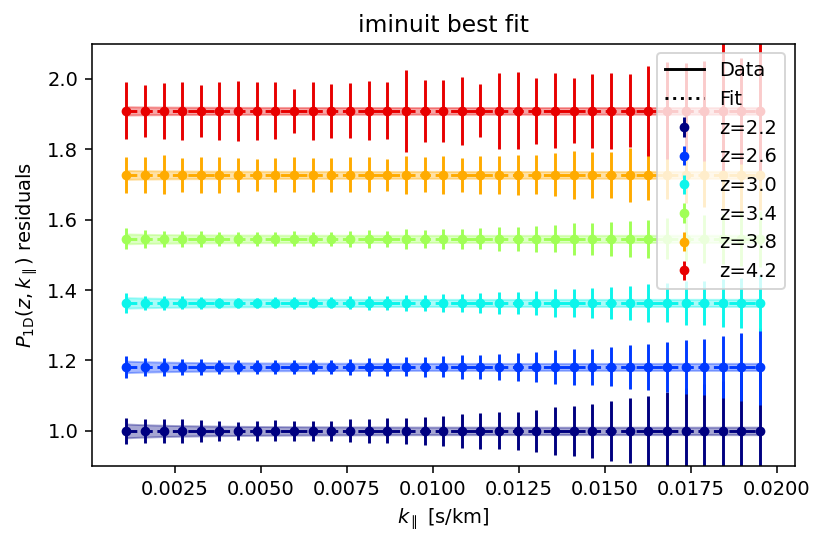

In [17]:
minimizer.plot_best_fit(plot_every_iz=2)

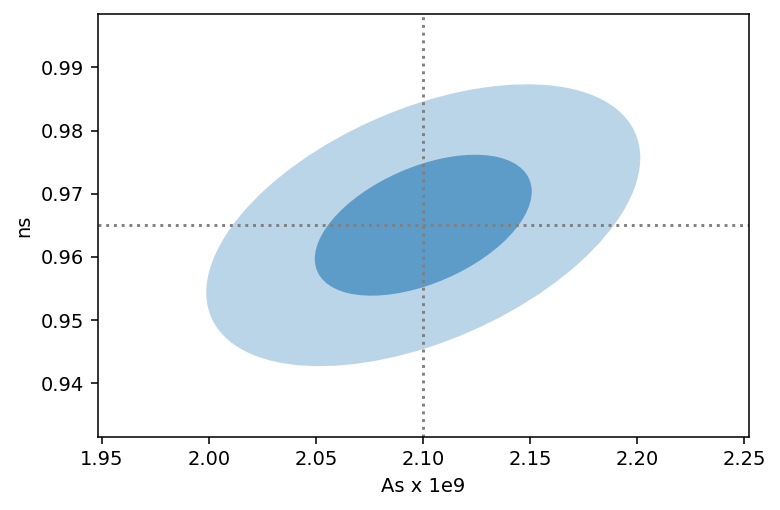

In [18]:
minimizer.plot_ellipses('As','ns')

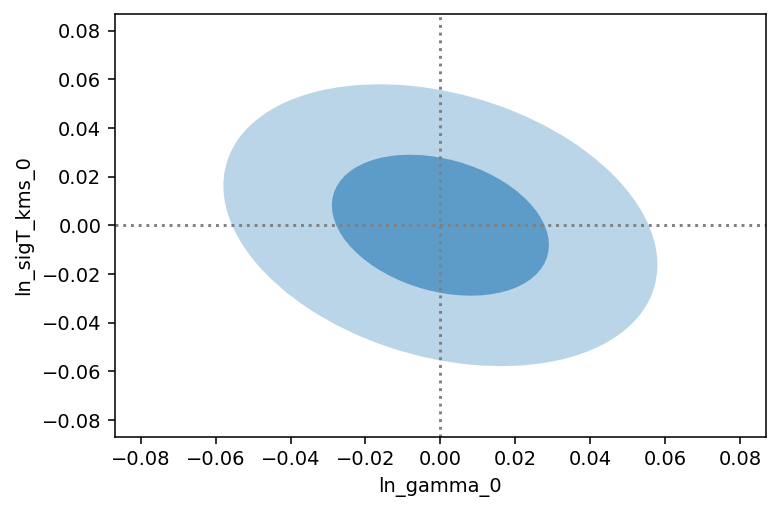

In [19]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

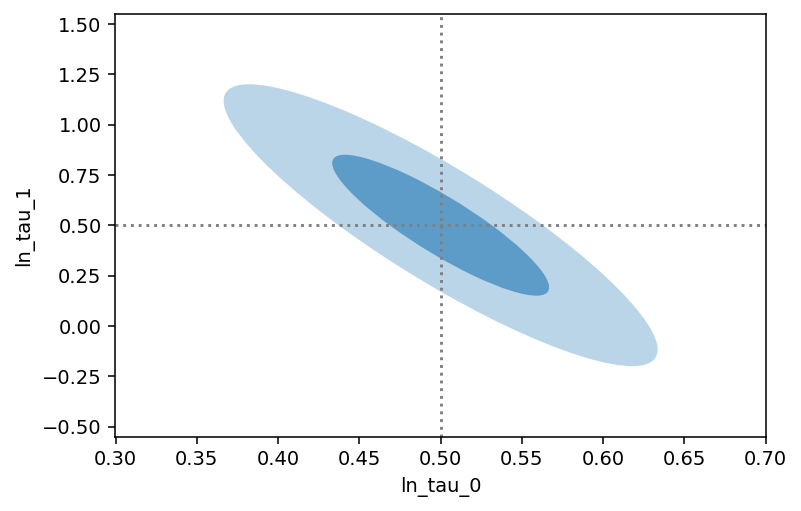

In [20]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [21]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 153.5                      │              Nfcn = 310              │
│ EDM = 1.61e-08 (Goal: 0.0001)    │           time = 24.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.500   │   0.023   │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.07    │            │            │         │         │       │
│ 2 │ x2   │   0.50    │   0.07    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.04    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.07    │            │            │         │         │       │
│ 5 │ x5   │   0.50    │   0.17    │            │            │         │         │       │
│ 6 │ x6   │   0.50    │   0.35    │            │            │         │         │       │
│ 7 │ x7   │    0.5    │    0.4    │            │            │         │         │       │
│ 8 │ x8   │    0.5    │    0.5    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.31    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │  0.000534  0.000665    -0.001  4.77e-05  -0.00039  -0.00162   0.00437  -0.00466   0.00576   0.00167 │
│ x1 │  0.000665   0.00445  -0.00351  0.000932   -0.0023   -0.0095    0.0176   -0.0205    0.0223   0.00695 │
│ x2 │    -0.001  -0.00351   0.00443  -0.00125   0.00348    0.0079   -0.0203    0.0228   -0.0262  -0.00743 │
│ x3 │  4.77e-05  0.000932  -0.00125   0.00128 -0.000652  -0.00263   0.00609  -0.00826   0.00896  0.000404 │
│ x4 │  -0.00039   -0.0023   0.00348 -0.000652   0.00517   0.00631   -0.0168    0.0193    -0.019   -0.0118 │
│ x5 │  -0.00162   -0.0095    0.0079  -0.00263   0.00631    0.0283   -0.0438    0.0517   -0.0553   -0.0305 │
│ x6 │   0.00437    0.0176   -0.0203   0.00609   -0.0168   -0.0438      0.12    -0.135     0.154    0.0465 │
│ x7 │  -0.00466   -0.0205    0.0228  -0.00826    0.0193    0.0517    -0.135     0.173    -0.164   -0.0646 │
│ x8 │   0.00576    0.0223   -0.0262   0.00896    -0.019   -0.0553     0.154    -0.164     0.214    0.0469 │
│ x9 │   0.00167   0.00695  -0.00743  0.000404   -0.0118   -0.0305    0.0465   -0.0646    0.0469    0.0971 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
minimizer.minimizer.errors

<ErrorView x0=0.02311137757747302 x1=0.06672565518182355 x2=0.06652875224221698 x3=0.03574140478742058 x4=0.07190201006313755 x5=0.16817814401810527 x6=0.3458695835736235 x7=0.4162096620360479 x8=0.46227599710484474 x9=0.31154752707744315>

In [23]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(-1.9854983548950322e-07, 0.013305750448443397)

In [25]:
minimizer.best_fit_value('ns',return_hesse=True)

(0.96499716606319, 0.011343361380910006)